# Question A.2

This notebook documents the development of a model that predicts returns $R_t$ using the log dividend growth $\Delta d_t$ and Price-to-Dividend ratio $PD_t$

## Libraries

For our model, we want to import the following libraries

In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression

## Data Loading

Our data is found in the `data.csv` file, and we first want to load it in.

In [126]:
#Read data.csv file from the data directory
df = pd.read_csv('../data/data.csv', index_col = [0])

# Inspect data
df

,date,Return_with_Dividends,Return_without_Dividends,RiskFree_Rate_1Month_Forward,Return_1Month_Forward,Sigma
0,1998-02-07,0.304277,0.143167,0.350638,0.055277,NaN
1,1998-02-10,0.291903,0.154534,0.363007,0.025068,NaN
2,1998-02-11,0.269282,0.179072,0.365795,0.043227,NaN
3,1998-02-12,0.290409,0.160366,0.377143,0.056165,NaN
4,1998-02-13,0.268346,0.149079,0.350271,0.074432,NaN
...,...,...,...,...,...,...
6256,2022-02-01,0.178304,0.067787,-0.005573,-0.042527,0.056470
6257,2022-02-02,0.194420,0.077617,0.003521,-0.039765,0.057842
6258,2022-02-03,0.178116,0.069139,0.000203,-0.047804,0.059506
6259,2022-02-04,0.172267,0.064309,0.002355,-0.075907,0.058272


## Exploratory Data Analysis

We now perform some exploratory data analysis to get a better feel for our data

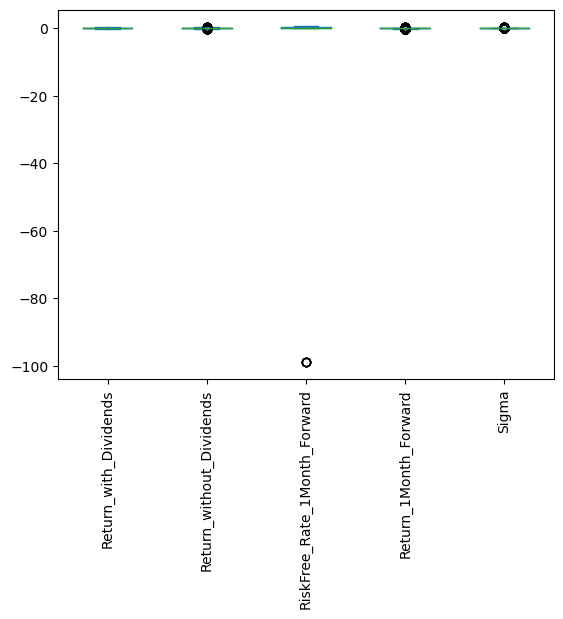

In [127]:
#Plot boxplots

df.plot(kind = 'box')
plt.xticks(rotation = 90)
plt.show()

We observe a severe outlier in `RiskFree_Rate_1Month_Forward`. Since it is almost -100, we can assume this is some measurement error, so to fit a model it will be wise to drop this

In [128]:
#Filter out observations where the foward riskfree rate is greater than 50
df = df.loc[abs(df['RiskFree_Rate_1Month_Forward']) < 50].copy()

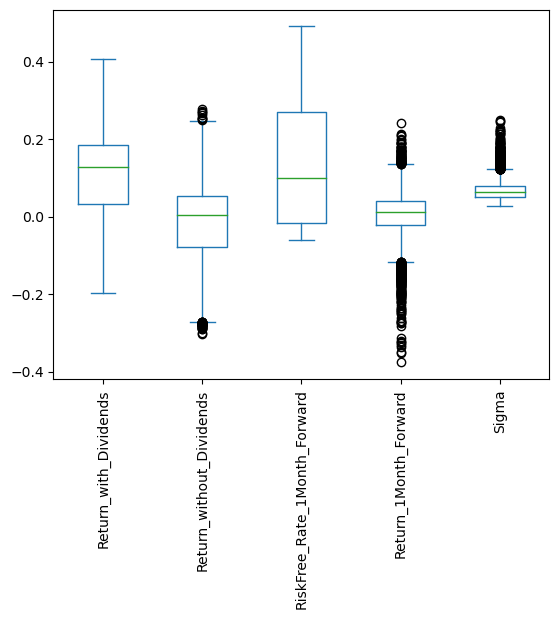

In [129]:
#Plot boxplots

df.plot(kind = 'box')
plt.xticks(rotation = 90)
plt.show()

Despite there still being outliers, these values are within a more reasonable range, and hence this will not effect the generalisation of our model

We now take a look at summary statistics of our data

In [130]:
#Summary statistics
df.describe()

,Return_with_Dividends,Return_without_Dividends,RiskFree_Rate_1Month_Forward,Return_1Month_Forward,Sigma
count,6256.000000,6256.000000,6256.000000,6231.000000,5995.000000
mean,0.109455,-0.012911,0.130775,0.006096,0.069852
std,0.108956,0.096957,0.151515,0.057892,0.027024
min,-0.197034,-0.302599,-0.061559,-0.376489,0.027157
25%,0.031608,-0.077261,-0.015332,-0.022481,0.051304
50%,0.127174,0.005096,0.099123,0.011737,0.064311
75%,0.185965,0.052129,0.269003,0.040565,0.079704
max,0.406503,0.277510,0.490552,0.240728,0.248792


Notably, we see that `Return_without_Dividends` has a negative mean, which implies that on average the value from the past year of the equity excluding dividends actually decreases. From this we can deduce that on average dividends plays a more important role in the value of the equity year on year

## Data Augmentation

We now wish to construct the variables $\Delta d_t$ and $PD_t$. Using the derivations from Question A.1, we have the following:

$$
    PD_t = \frac{V_t + 1}{H_t - V_t}
$$

$$
  \Delta d_t = \log \left ( (H_t - V_t)(V_{t-1} + 1 ) \right) - \log \left ( H_{t-1} - V_{t-1} \right)
$$

### Price-to-Dividend Ratio $PD_t$

In order to calculate the Price-to-Dividend ratio, we can simply augment the dataframe `df` to calculate this value given the formula. 

In [131]:
#Define the H_t and V_t columns
H_t = df["Return_with_Dividends"]
V_t = df["Return_without_Dividends"]

#Augment a column PD_t which applies the relevant function
df['PD_t'] = (V_t+1)/(H_t - V_t)

### Log dividend growth $\Delta d_t$

We can again apply the formula for $\Delta d_t$ listed above to augment the data.

In [132]:
#Augment a column delta_d which applies the relevant function
df["delta_d"] = np.log((H_t.shift() - V_t.shift())*(V_t+1)) - np.log(H_t - V_t)

### Augmented data

We can now inspect our new, augmented data.

In [133]:
#Print data
df.head()

,date,Return_with_Dividends,Return_without_Dividends,RiskFree_Rate_1Month_Forward,Return_1Month_Forward,Sigma,PD_t,delta_d
0,1998-02-07,0.304277,0.143167,0.350638,0.055277,NaN,7.095540,NaN
1,1998-02-10,0.291903,0.154534,0.363007,0.025068,NaN,8.404637,0.303119
2,1998-02-11,0.269282,0.179072,0.365795,0.043227,NaN,13.070375,0.585262
3,1998-02-12,0.290409,0.160366,0.377143,0.056165,NaN,8.922924,-0.216997
4,1998-02-13,0.268346,0.149079,0.350271,0.074432,NaN,9.634514,0.225464


In [136]:
df.dropna(inplace = True)

## Further Exploratory Data Analysis

Before fitting models, we can perform some more exploratory data analysis on our augmented data

In [137]:
#Summary Statistics
df.describe()

,Return_with_Dividends,Return_without_Dividends,RiskFree_Rate_1Month_Forward,Return_1Month_Forward,Sigma,PD_t,delta_d
count,5971.000000,5971.000000,5971.000000,5971.000000,5971.000000,5971.000000,5971.000000
mean,0.102810,-0.018293,0.121496,0.005252,0.069832,8.535103,-0.023104
std,0.105308,0.094029,0.147965,0.056380,0.027029,2.327232,0.249851
min,-0.197034,-0.302599,-0.061559,-0.376489,0.027157,4.440278,-1.404444
25%,0.025011,-0.081317,-0.021998,-0.022905,0.051291,7.051794,-0.175724
50%,0.120728,0.001013,0.076496,0.010877,0.064296,8.063557,-0.015668
75%,0.178863,0.047718,0.250311,0.039029,0.079680,9.408249,0.135393
max,0.406503,0.277510,0.490552,0.211338,0.248792,54.194632,1.160398


Although the Price-to-Dividend ratio has a far larger magnitude than the other predictors, since it is a calculated value from the clean data we will keep it in our models

As given, our team hypothesises that we can predict returns using $PD_t$ and $\Delta d_t$. So we now wish to visualise the relationship between these two variables, to inform model selection.

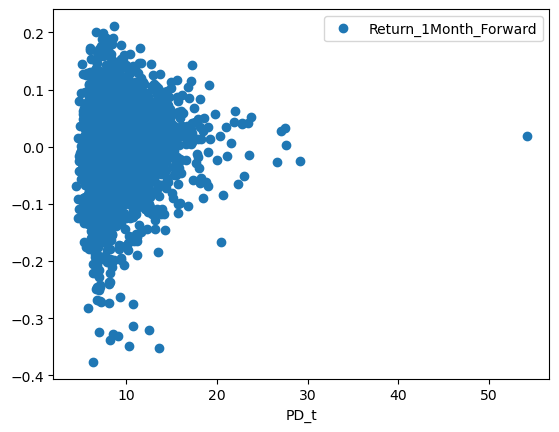

In [138]:
df.plot(x='PD_t', y='Return_1Month_Forward', style='o')
plt.show()

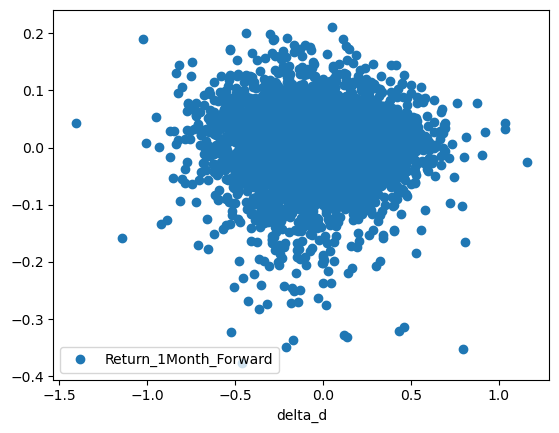

In [139]:
df.plot(x='delta_d', y='Return_1Month_Forward', style='o')
plt.show()

We observe that there may be a small non-linear relationship between $PD_t$ and $R_t$, but there appears to be no discernable relationship between $\Delta d_t$ and $R_t$

## Fitting Models

This section documents the construction, fitting, and tuning of various models

### Linear Regression

In [140]:
X = df[['PD_t', 'delta_d']]
y = df['Return_1Month_Forward']
model = LinearRegression().fit(X,y)

In [142]:
print(f"coefficient of determination: {model.score(X,y)}")
print(f"intercept: {model.intercept_}")
print(f"coefficients: {model.coef_}")

coefficient of determination: 0.0015781006173752887
intercept: -0.0037632647933491152
coefficients: [ 0.00105069 -0.00206148]


By the low coefficient of determination, we observe that this model is extremely poor